# RC Temporal Subsampling
## NRMSE and NRMSE + KE NRMSE Macro Cost

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [2]:
sys.path.append("..")
from rcgfd import RCDataset, BigPlot, SingleTimePlot, plot_ke_relerr, MetricsPlot

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
rcd = RCDataset(
    n_sub=[1, 4, 16],
    cost_terms = [
        {"nrmse": 1},
        #{"nrmse": 1, "spectral": 1e-3},
        {"nrmse": 1, "spectral": 1e-2},
        {"nrmse": 1, "spectral": 1e-1},
        #{"nrmse": 1, "spectral": 1.0},
    ]
)

In [6]:
%%time
ds = rcd()

CPU times: user 35.4 s, sys: 7.84 s, total: 43.2 s
Wall time: 37.1 s


In [7]:
#ds["gamma"] = xr.DataArray([0., 1e-3, 1e-2, 1e-1, 1.0], coords=ds.experiment.coords, dims=ds.experiment.dims)
ds["gamma"] = xr.DataArray([0., 1e-2, 1e-1], coords=ds.experiment.coords, dims=ds.experiment.dims)
ds = ds.swap_dims({"experiment":"gamma"})

## Qualitative Plots

In [8]:
stp = SingleTimePlot(diff_t0=False, time=4*3600)

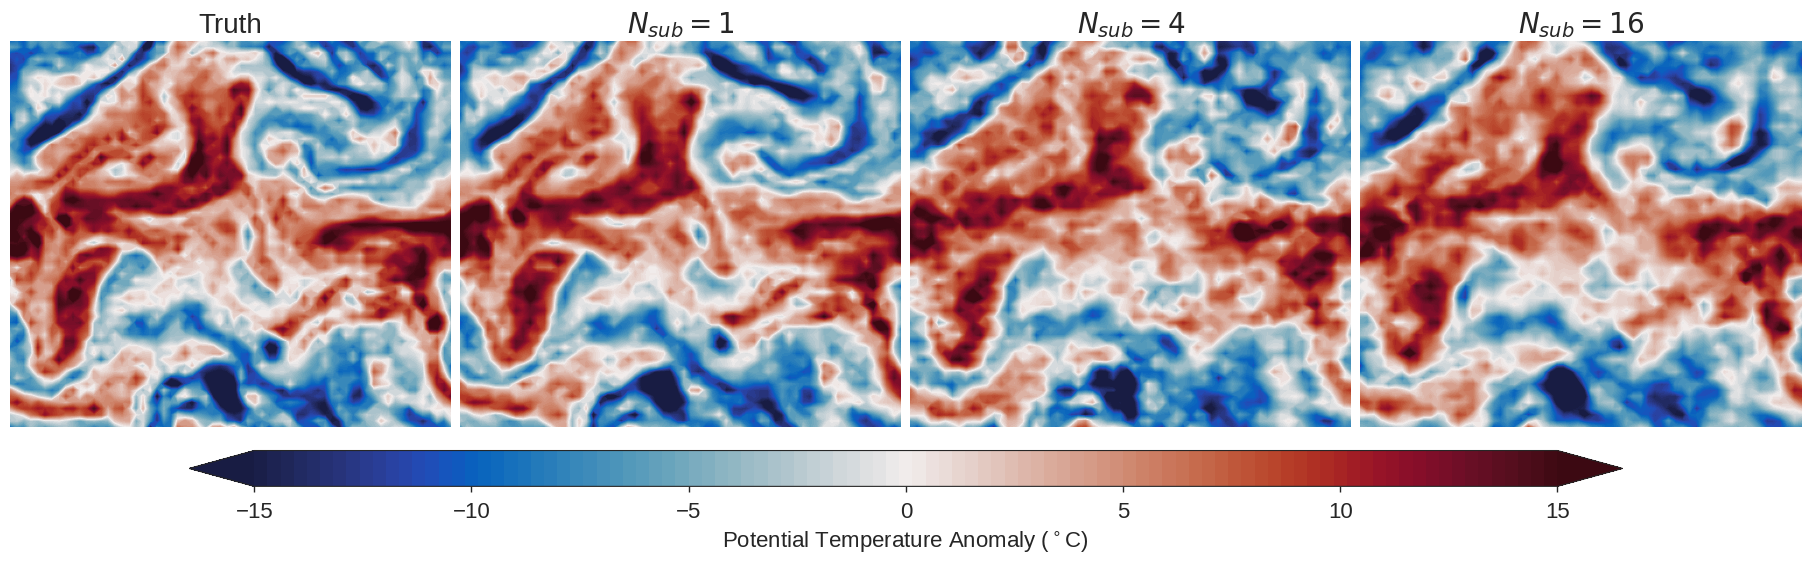

In [9]:
fig, axs = stp(ds.sel(gamma=0.1, sample=49), col_dim="n_sub")
[ax.set(title=r"$N_{sub} = %d$" % n_sub) for n_sub, ax in zip(ds.n_sub.values, axs[1:])];
fig.savefig(f"{fig_dir}/rc_qualitative_nsub.jpg", bbox_inches="tight")

In [10]:
gamma_label = lambda g : r"$\gamma = 0$" if g == 0 else r"$\gamma = 10^{%d}$" % np.log10(g)

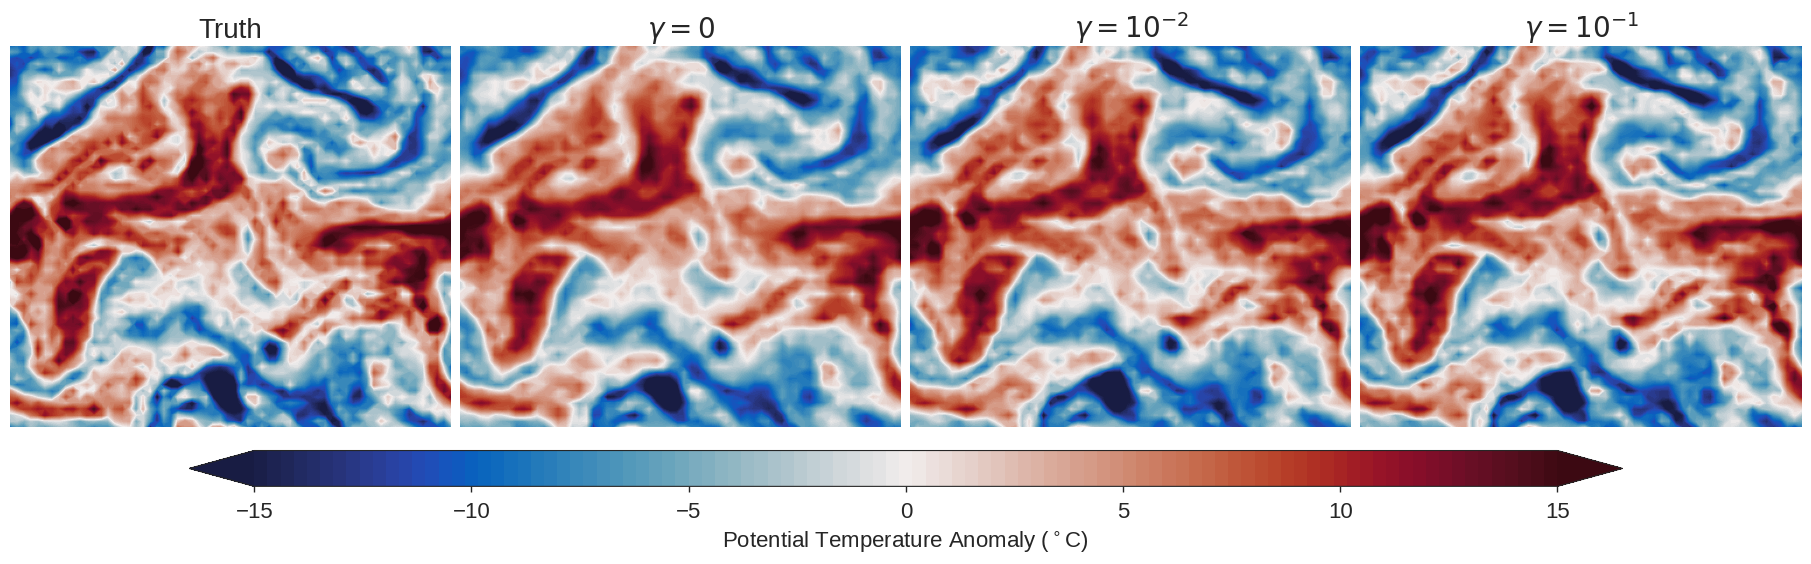

In [11]:
fig, axs = stp(ds.sel(n_sub=1, sample=49), col_dim="gamma")
[ax.set(title=gamma_label(gamma)) for gamma, ax in zip(ds.gamma.values, axs[1:])];
fig.savefig(f"{fig_dir}/rc_qualitative_gamma.jpg", bbox_inches="tight")

## Metrics

- Note that even though the penalty is different here than in the other notebook,
  it is easiest to use KE NRMSE instead of KE RMSE to compare runs
- The NRMSE compares to what the spectrum error shows
- And it doesn't matter how the plots are normalized, but using standard deviation is easier to visualize

In [8]:
ds['nrmse'].load();

### Compare at Nsub=1

In [9]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse", "ke_nrmse"),
    cdim="gamma",
)

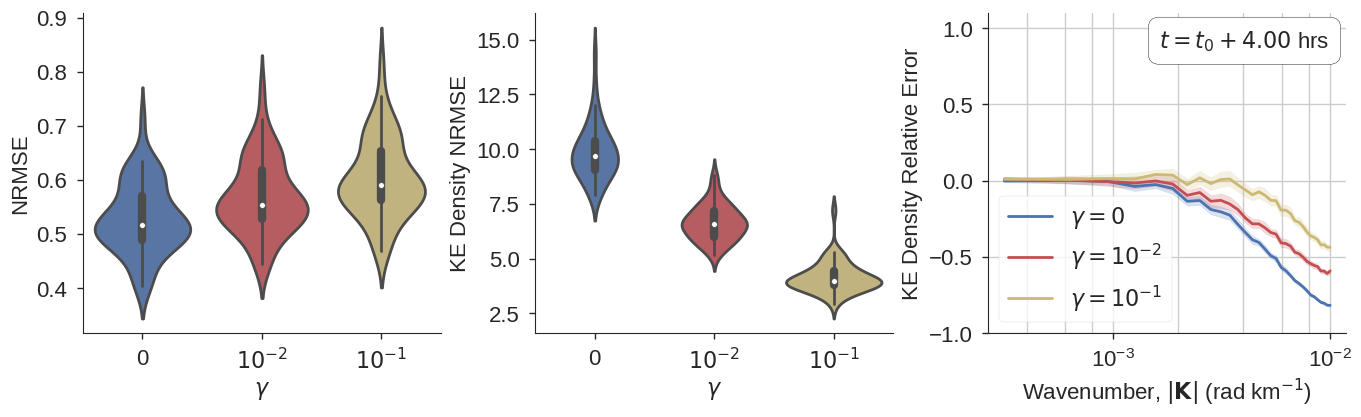

In [10]:
fig, axs = mp(ds.sel(n_sub=1, gamma=[0., 0.01, 0.1]), show_time=False)
[ax.set(xlabel="$\gamma$",
        xticklabels=["0", r"$10^{-2}$", r"$10^{-1}$"],
       ) for ax in axs[:-1]]
axs[-1].clear()

fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=1, gamma=[0,0.01,0.1]),
    fig=fig,
    axs=axs[-1:],
    hours=(4,),
    cdim="gamma",
    clabel=mp.gamma_label,
)
axs[-1].legend(loc="lower left", ncol=1, frameon=True)
fig.savefig(f"{fig_dir}/rc_all_nsub01.pdf", bbox_inches="tight")

### Compare across Nsub

In [11]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse", "ke_nrmse"),
    cdim="n_sub",
)

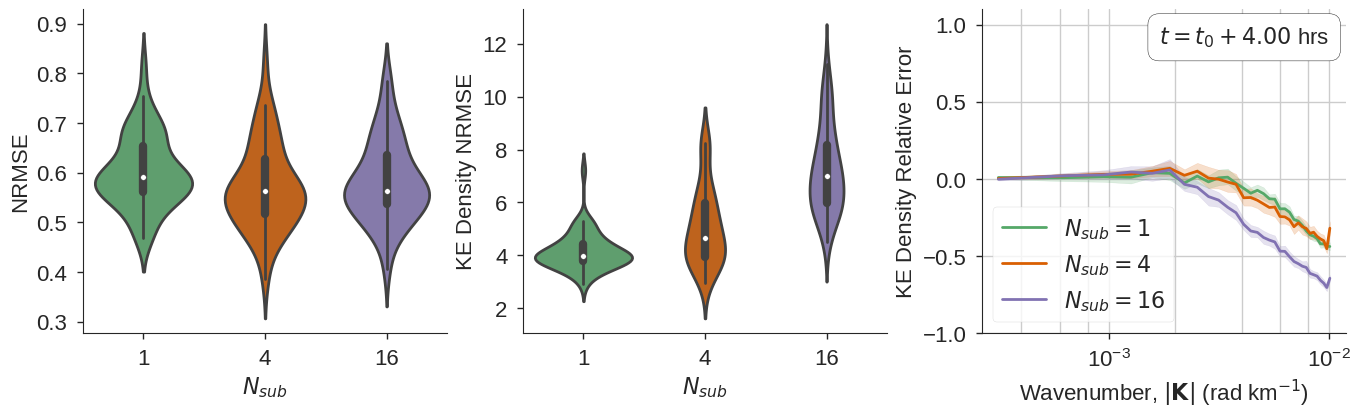

In [12]:
fig, axs = mp(ds.sel(gamma=0.1), show_time=False)
[ax.set(xlabel="$N_{sub}$") for ax in axs[:-1]]
axs[-1].clear()

fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(gamma=0.1),
    fig=fig,
    axs=axs[-1:],
    hours=(4,),
    cdim="n_sub",
)
axs[-1].legend(loc="lower left", ncol=1, frameon=True)
fig.savefig(f"{fig_dir}/rc_all_gamma0.1.pdf", bbox_inches="tight")

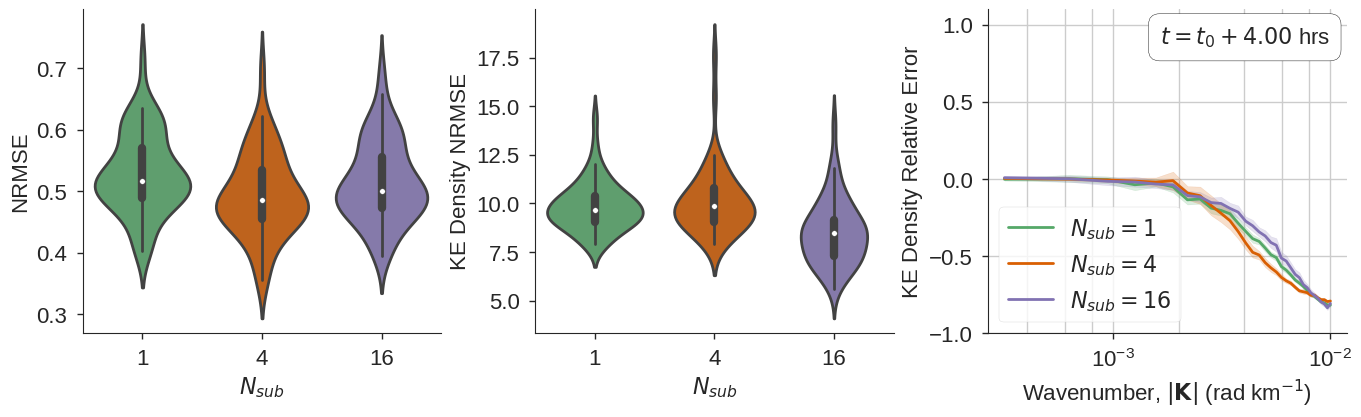

In [13]:
fig, axs = mp(ds.sel(gamma=0), show_time=False)
[ax.set(xlabel="$N_{sub}$") for ax in axs[:-1]]
axs[-1].clear()

fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(gamma=0),
    fig=fig,
    axs=axs[-1:],
    hours=(4,),
    cdim="n_sub",
)
axs[-1].legend(loc="lower left", ncol=1, frameon=True)
fig.savefig(f"{fig_dir}/rc_all_gamma0.0.pdf", bbox_inches="tight")

## Many more plots...

### $N_{sub}=16$

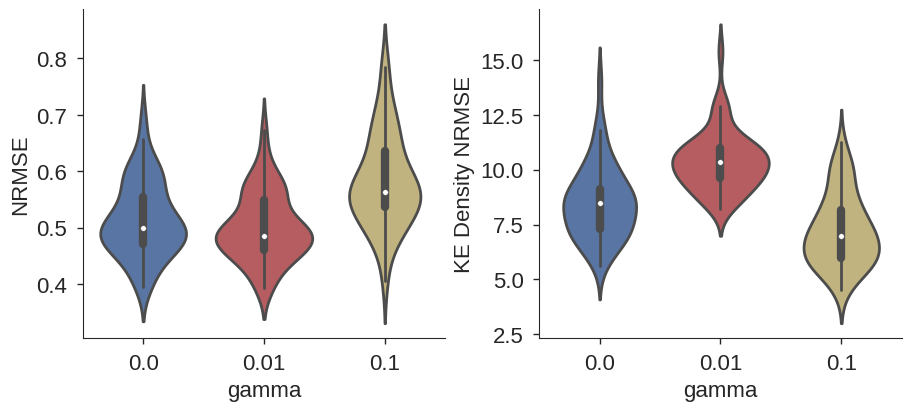

In [18]:
fig, axs = mp(ds.sel(n_sub=16), show_time=False)

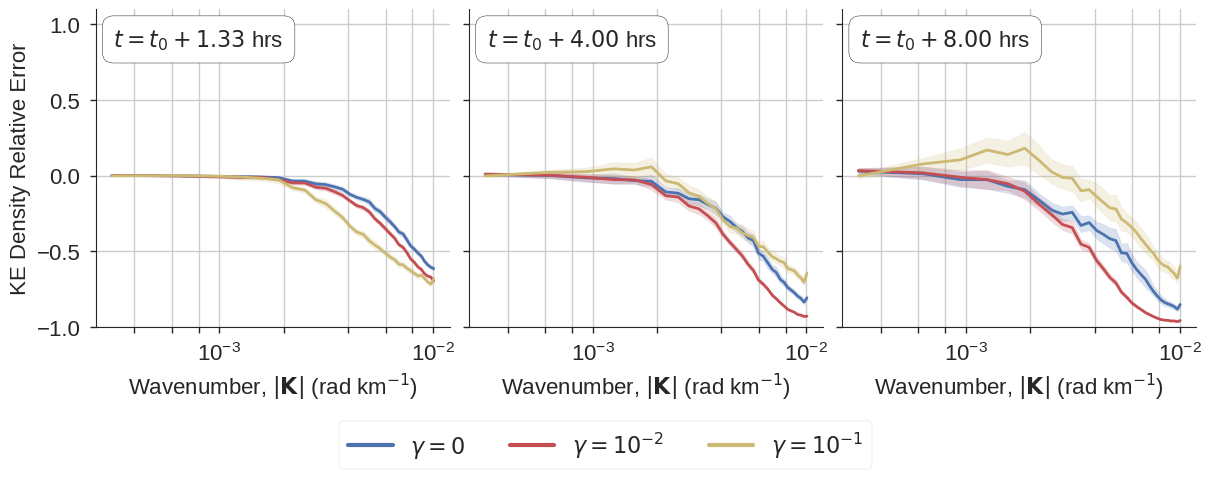

In [19]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=16),
    cdim="gamma",
    clabel=mp.gamma_label)

- Consider either $\gamma = 0$ or $\gamma = 0.1$, we have a tradeoff between NRMSE and KE NRMSE
- However, the KE NRMSE is a bit nuanced here: spectral bias is better at higher wavenumbers
  (about $|\mathbf{K}|\gt 3\cdot10^{-3}$), but there's a tradeoff in the sense that the smaller wavenumbers 
  are worse
- So which is better depends on a matter of taste...
- Similar to KE RMSE case, using an intermediate value of $\gamma$ tends to produce runs that are *more* blurry than
  using $\gamma = 0$.

Even though 

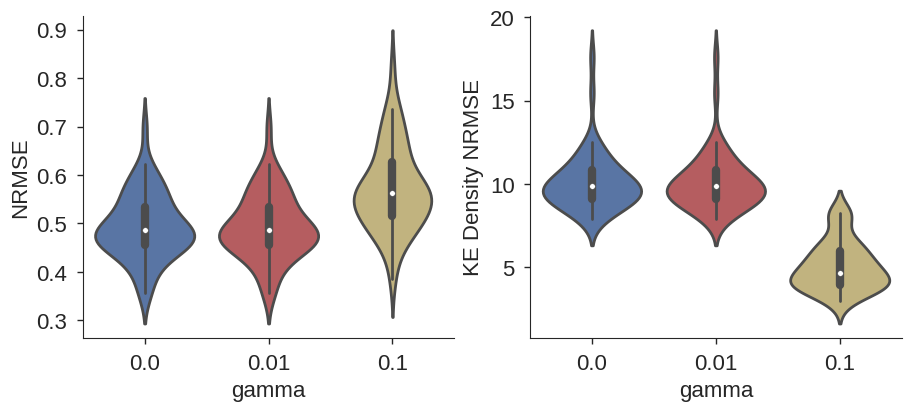

In [20]:
fig, axs = mp(ds.sel(n_sub=4), show_time=False)

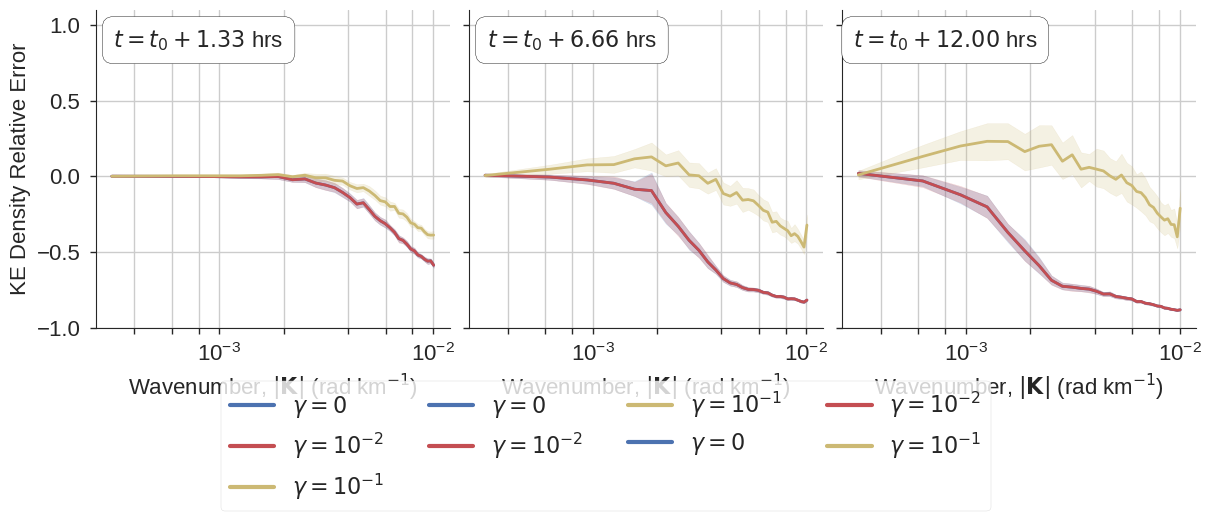

In [21]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=4),
    cdim="gamma",
    hours=(1.33,6.66,12),
    clabel=mp.gamma_label)

### The model timestep, $N_{sub}=1$

In [22]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="gamma",
)

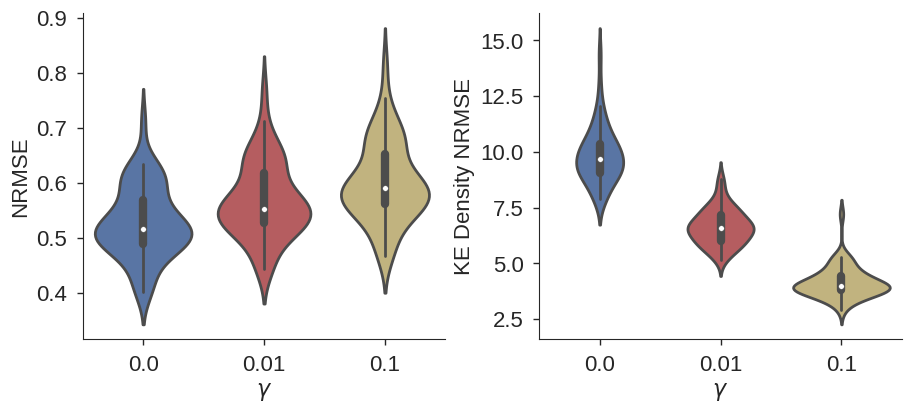

In [23]:
fig, axs = mp(ds.sel(n_sub=1, gamma=[0., 0.01, 0.1]), show_time=False)
[ax.set(xlabel="$\gamma$") for ax in axs];

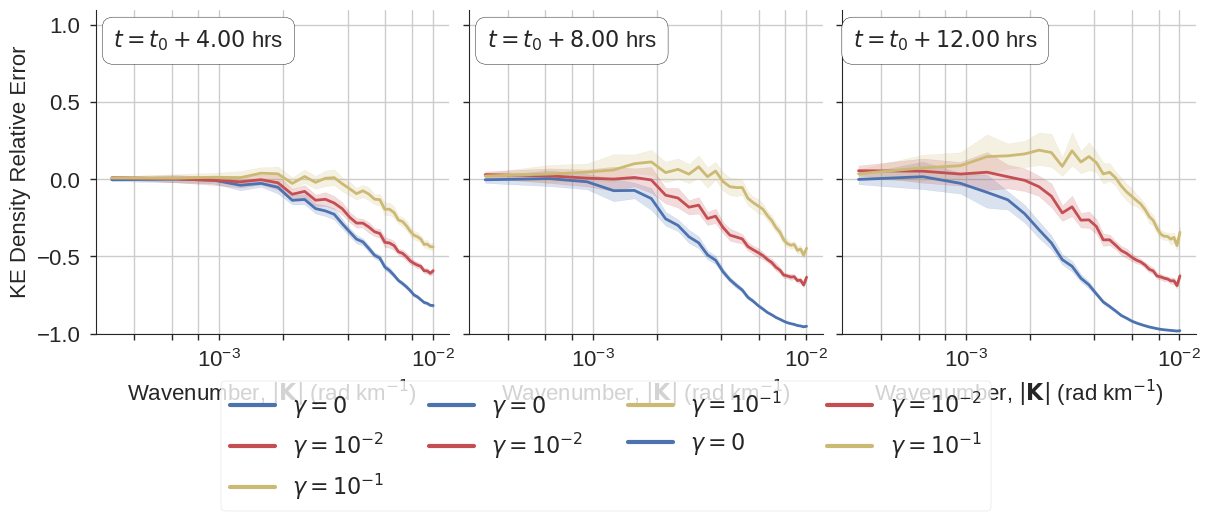

In [24]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=1, gamma=[0, 0.01, 0.1]),
    cdim="gamma",
    hours=(4, 8, 12),
    clabel=mp.gamma_label)
#fig.savefig(f"{fig_dir}/rc_ke_rel_err_nsub01.pdf", bbox_inches="tight")

## Compare $N_{sub}$

In [24]:
nsp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="n_sub",
)

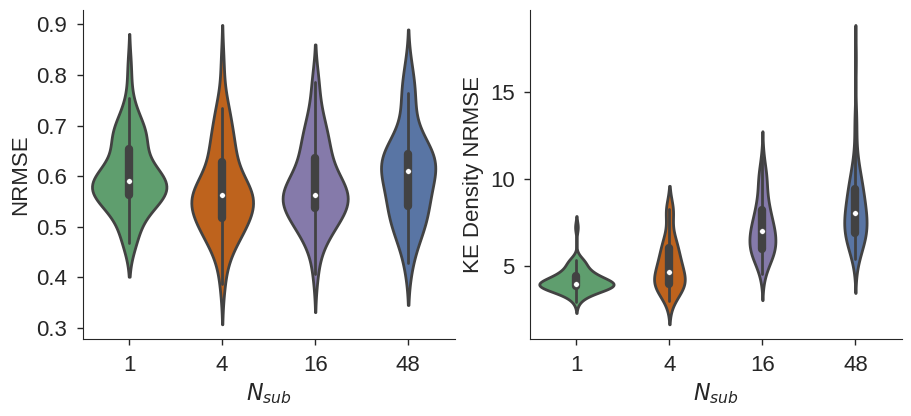

In [25]:
fig, axs = nsp(ds.sel(gamma=0.1), show_time=False)
[ax.set(xlabel=r"$N_{sub}$") for ax in axs]
#fig.savefig(f"{fig_dir}/rc_nrmse_kenrmse_gamma0.1.pdf", bbox_inches="tight")

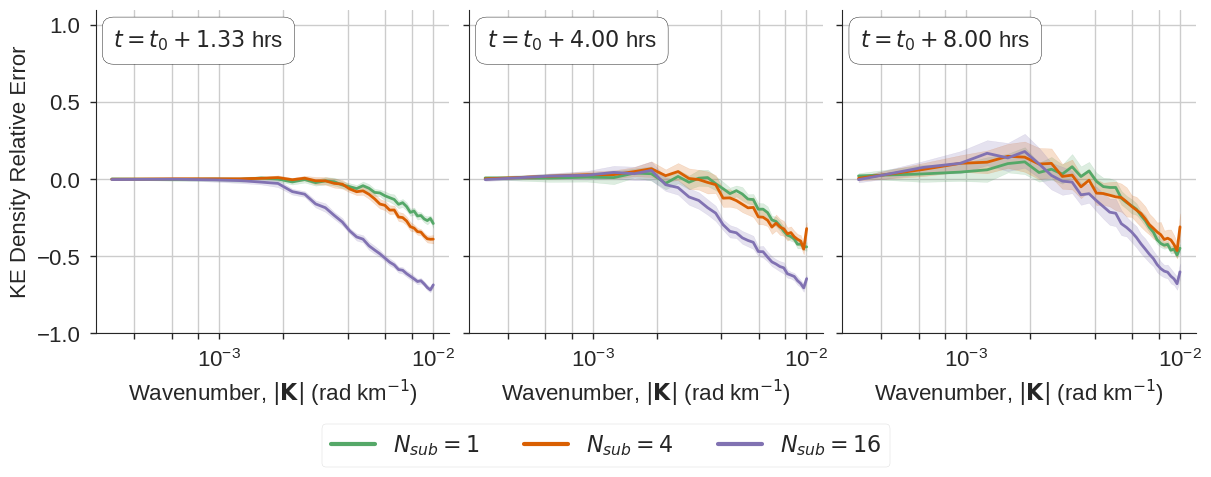

In [26]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(gamma=0.1, n_sub=slice(30)),
    cdim="n_sub",
)
#fig.savefig(f"{fig_dir}/rc_ke_rel_err_gamma0.1.pdf", bbox_inches="tight")

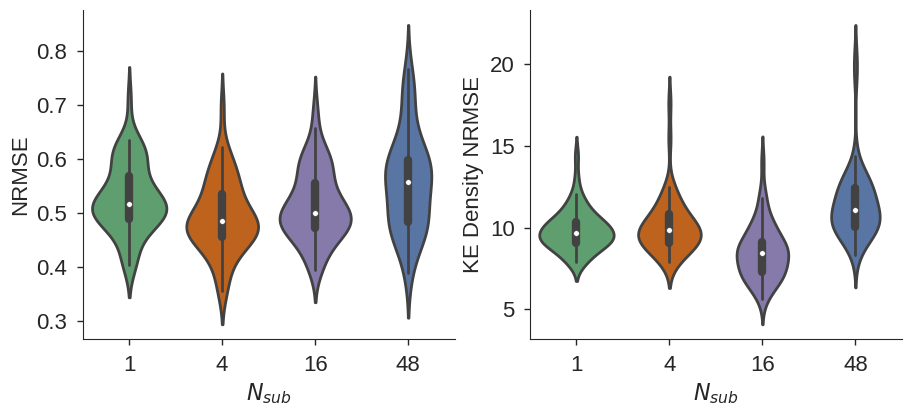

In [27]:
fig, axs = nsp(ds.sel(gamma=0.), show_time=False)
[ax.set(xlabel=r"$N_{sub}$") for ax in axs]
#fig.savefig(f"{fig_dir}/rc_nrmse_kenrmse_gamma0.0.pdf", bbox_inches="tight")

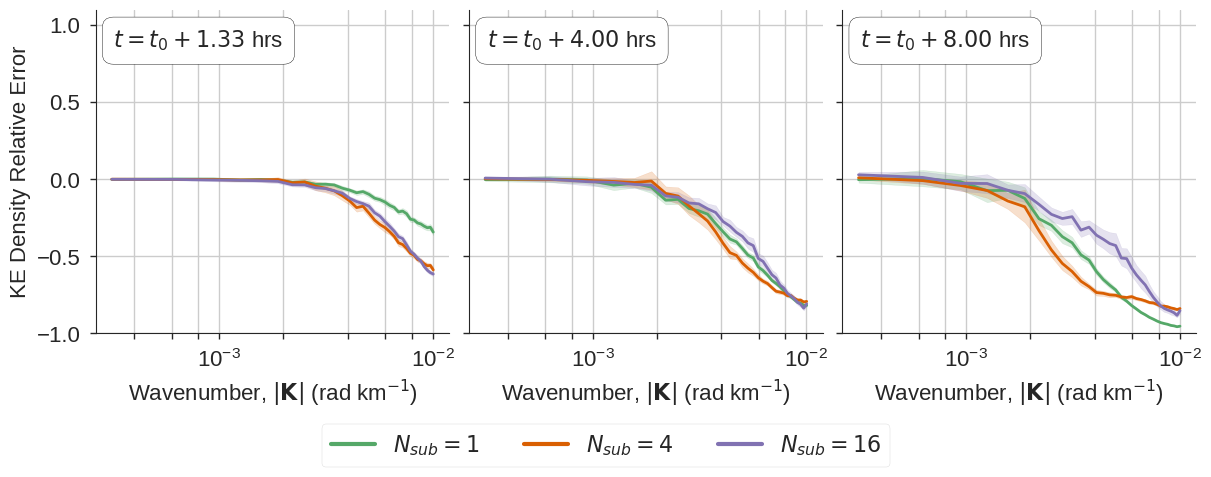

In [28]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(gamma=0., n_sub=slice(30)),
    cdim="n_sub",
)
#fig.savefig(f"{fig_dir}/rc_ke_rel_err_gamma0.0.pdf", bbox_inches="tight")